# The Unit Commitment Problem (UCP)

This sample is concerned with how an electricity provider can decide which power generators to run and at what levels in order to satisfy demand for electricity.  
This tutorial includes everything you need to set up IBM Decision Optimization CPLEX Modeling for Python (DOcplex), build a Mathematical Programming model, and solve the model with IBM ILOG CPLEX Optimizer.

Table of contents:

*  [Describe the business problem](#Describe-the-business-problem)
*  [How decision optimization (prescriptive analytics) can help](#How--decision-optimization-can-help)
*  [Use decision optimization](#Use-decision-optimization)
    *  [Step 1: Model the Data](#Step-1:-Model-the-data)
    *  [Step 2: Prepare the data](#Step-2:-Prepare-the-data)
    *  [Step 3: Set up the prescriptive model](#Step-3:-Set-up-the-prescriptive-model)
        * [Define the decision variables](#Define-the-decision-variables)
        * [Express the business constraints](#Express-the-business-constraints)
        * [Express the objective](#Express-the-objective)
        * [Solve with Decision Optimization](#Solve-with-Decision-Optimization)
    *  [Step 4: Investigate the solution and run an example analysis](#Step-4:-Investigate-the-solution-and-then-run-an-example-analysis)
*  [Summary](#Summary)

****

## Describe the business problem

* The model estimates the lowest cost of generating electricity within a given plan. 
Depending on the demand for electricity, units that generate power and which have operational properties and costs can be turned on or off.

* The Unit Commitment Problem answers the question "Which power generators should I run at which times and at what level in order to satisfy the demand for electricity?" This  model helps users to find not only a feasible answer to the question, but one that also optimizes its solution to meet as many of the electricity company's overall goals as possible. 


## How  decision optimization can help

* Prescriptive analytics (decision optimization) technology recommends actions that are based on desired outcomes.  It takes into account specific scenarios, resources, and knowledge of past and current events. With this insight, your organization can make better decisions and have greater control of business outcomes.  

* Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

* Prescriptive analytics takes predictive insight to the next level by suggesting the optimal way to handle a future situation. Organizations that can act quickly in dynamic conditions and make superior decisions in uncertain environments gain a strong competitive advantage.  
<br/>

<u>With prescriptive analytics, you can:</u> 

* Automate the complex decisions and trade-offs to better manage your limited resources.
* Take advantage of a future opportunity or mitigate a future risk.
* Proactively update recommendations based on changing events.
* Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.

## Checking minimum requirements
This notebook uses some features of *pandas* that are available in version 0.17.1 or above.

In [1]:
import pip
REQUIRED_MINIMUM_PANDAS_VERSION = '0.17.1'
try:
    import pandas as pd
    assert pd.__version__ >= REQUIRED_MINIMUM_PANDAS_VERSION
except:
    raise Exception("Version " + REQUIRED_MINIMUM_PANDAS_VERSION + " or above of Pandas is required to run this notebook")

## Use decision optimization

### Step 1: Model the data
#### Load data from a *pandas* DataFrame

Data for the Unit Commitment Problem is provided as a *pandas* DataFrame.
For a standalone notebook, the raw data is provided as Python collections,
but real data could be loaded
from an Excel sheet, also using *pandas*.

In [2]:
import pandas as pd
from pandas import DataFrame, Series

# make matplotlib plots appear inside the notebook
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 11, 5 ############################ <-Use this to change the plot

Update the configuration of notebook so that display matches browser window width.

In [3]:
from IPython.core.display import HTML
HTML("<style>.container { width:100%; }</style>")

#### Available energy technologies

The following *df_energy* DataFrame stores CO<sub>2</sub> cost information, indexed by energy type.

In [4]:
energies = ["coal", "gas", "diesel", "wind"]
df_energy = DataFrame({"co2_cost": [30, 5, 15, 0]}, index=energies)

# Display the 'df_energy' Data Frame
df_energy

,co2_cost
coal,30
gas,5
diesel,15
wind,0


The following *df_units* DataFrame stores common elements for units of a given technology.

In [5]:
all_units = ["coal1", "coal2", 
             "gas1", "gas2", "gas3", "gas4", 
             "diesel1", "diesel2", "diesel3", "diesel4"]
             
ucp_raw_unit_data = {
        "energy": ["coal", "coal", "gas", "gas", "gas", "gas", "diesel", "diesel", "diesel", "diesel"],
        "initial" : [400, 350, 205, 52, 155, 150, 78, 76, 0, 0],
        "min_gen": [100, 140, 78, 52, 54.25, 39, 17.4, 15.2, 4, 2.4],
        "max_gen": [425, 365, 220, 210, 165, 158, 90, 87, 20, 12],
        "operating_max_gen": [400, 350, 205, 197, 155, 150, 78, 76, 20, 12],
        "min_uptime": [15, 15, 6, 5, 5, 4, 3, 3, 1, 1],
        "min_downtime":[9, 8, 7, 4, 3, 2, 2, 2, 1, 1],
        "ramp_up":   [212, 150, 101.2, 94.8, 58, 50, 40, 60, 20, 12],
        "ramp_down": [183, 198, 95.6, 101.7, 77.5, 60, 24, 45, 20, 12],
        "start_cost": [5000, 4550, 1320, 1291, 1280, 1105, 560, 554, 300, 250],
        "fixed_cost": [208.61, 117.37, 174.12, 172.75, 95.353, 144.52, 54.417, 54.551, 79.638, 16.259],
        "variable_cost": [22.536, 31.985, 70.5, 69, 32.146, 54.84, 40.222, 40.522, 116.33, 76.642],
        }

df_units = DataFrame(ucp_raw_unit_data, index=all_units)

# Display the 'df_units' Data Frame
df_units

,energy,fixed_cost,initial,max_gen,min_downtime,min_gen,min_uptime,operating_max_gen,ramp_down,ramp_up,start_cost,variable_cost
coal1,coal,208.610,400,425,9,100.00,15,400,183.0,212.0,5000,22.536
coal2,coal,117.370,350,365,8,140.00,15,350,198.0,150.0,4550,31.985
gas1,gas,174.120,205,220,7,78.00,6,205,95.6,101.2,1320,70.500
gas2,gas,172.750,52,210,4,52.00,5,197,101.7,94.8,1291,69.000
gas3,gas,95.353,155,165,3,54.25,5,155,77.5,58.0,1280,32.146
gas4,gas,144.520,150,158,2,39.00,4,150,60.0,50.0,1105,54.840
diesel1,diesel,54.417,78,90,2,17.40,3,78,24.0,40.0,560,40.222
diesel2,diesel,54.551,76,87,2,15.20,3,76,45.0,60.0,554,40.522
diesel3,diesel,79.638,0,20,1,4.00,1,20,20.0,20.0,300,116.330
diesel4,diesel,16.259,0,12,1,2.40,1,12,12.0,12.0,250,76.642


### Step 2: Prepare the data

The *pandas* *merge* operation is used to create a join between the *df_units* and *df_energy* DataFrames. Here, the join is performed based on the *'energy'* column of *df_units* and index column of *df_energy*.

By default, *merge* performs an *inner* join. That is, the resulting DataFrame is based on the **intersection** of keys from both input DataFrames.

In [6]:
# Add a derived co2-cost column by merging with df_energies
# Use energy key from units and index from energy dataframe
df_up = pd.merge(df_units, df_energy, left_on="energy", right_index=True)
df_up.index.names=['units']

# Display first rows of new 'df_up' Data Frame
df_up.head()

,energy,fixed_cost,initial,max_gen,min_downtime,min_gen,min_uptime,operating_max_gen,ramp_down,ramp_up,start_cost,variable_cost,co2_cost
units,,,,,,,,,,,,,
coal1,coal,208.610,400,425,9,100.00,15,400,183.0,212.0,5000,22.536,30
coal2,coal,117.370,350,365,8,140.00,15,350,198.0,150.0,4550,31.985,30
gas1,gas,174.120,205,220,7,78.00,6,205,95.6,101.2,1320,70.500,5
gas2,gas,172.750,52,210,4,52.00,5,197,101.7,94.8,1291,69.000,5
gas3,gas,95.353,155,165,3,54.25,5,155,77.5,58.0,1280,32.146,5


The demand is stored as a *pandas* _Series_ indexed from 1 to the number of periods.

nb periods = 192


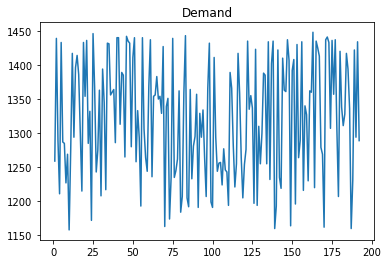

In [7]:
raw_demand = [1259.0, 1439.0, 1289.0, 1211.0, 1433.0, 1287.0, 1285.0, 1227.0, 1269.0, 1158.0, 1277.0, 1417.0, 1294.0, 1396.0, 1414.0, 1386.0,
              1302.0, 1215.0, 1433.0, 1354.0, 1436.0, 1285.0, 1332.0, 1172.0, 1446.0, 1367.0, 1243.0, 1275.0, 1363.0, 1208.0, 1394.0, 1345.0, 
              1217.0, 1432.0, 1431.0, 1356.0, 1360.0, 1364.0, 1286.0, 1440.0, 1440.0, 1313.0, 1389.0, 1385.0, 1265.0, 1442.0, 1435.0, 1432.0, 
              1280.0, 1411.0, 1440.0, 1258.0, 1333.0, 1293.0, 1193.0, 1440.0, 1306.0, 1264.0, 1244.0, 1368.0, 1437.0, 1236.0, 1354.0, 1356.0, 
              1383.0, 1350.0, 1354.0, 1329.0, 1427.0, 1163.0, 1339.0, 1351.0, 1174.0, 1235.0, 1439.0, 1235.0, 1245.0, 1262.0, 1362.0, 1184.0, 
              1207.0, 1359.0, 1443.0, 1205.0, 1192.0, 1364.0, 1233.0, 1281.0, 1295.0, 1357.0, 1191.0, 1329.0, 1294.0, 1334.0, 1265.0, 1207.0, 
              1365.0, 1432.0, 1199.0, 1191.0, 1411.0, 1294.0, 1244.0, 1256.0, 1257.0, 1224.0, 1277.0, 1246.0, 1243.0, 1194.0, 1389.0, 1366.0, 
              1282.0, 1221.0, 1255.0, 1417.0, 1358.0, 1264.0, 1205.0, 1254.0, 1276.0, 1435.0, 1335.0, 1355.0, 1337.0, 1197.0, 1423.0, 1194.0, 
              1310.0, 1255.0, 1300.0, 1388.0, 1385.0, 1255.0, 1434.0, 1232.0, 1402.0, 1435.0, 1160.0, 1193.0, 1422.0, 1235.0, 1219.0, 1410.0, 
              1363.0, 1361.0, 1437.0, 1407.0, 1164.0, 1392.0, 1408.0, 1196.0, 1430.0, 1264.0, 1289.0, 1434.0, 1216.0, 1340.0, 1327.0, 1230.0, 
              1362.0, 1360.0, 1448.0, 1220.0, 1435.0, 1425.0, 1413.0, 1279.0, 1269.0, 1162.0, 1437.0, 1441.0, 1433.0, 1307.0, 1436.0, 1357.0, 
              1437.0, 1308.0, 1207.0, 1420.0, 1338.0, 1311.0, 1328.0, 1417.0, 1394.0, 1336.0, 1160.0, 1231.0, 1422.0, 1294.0, 1434.0, 1289.0]
nb_periods = len(raw_demand)
print("nb periods = {}".format(nb_periods))

demand = Series(raw_demand, index = range(1, nb_periods+1))

# plot demand
demand.plot(title="Demand")

### Step 3: Set up the prescriptive model

Set up the prescriptive model using  Mathematical Programming (docplex.mp) modeling package.

In [8]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Linux 64bit
* Python is present, version is 3.5.5
* docplex is present, version is (2, 8, 125)
* CPLEX wrapper is present, version is 12.8.0.0, located at: /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages


#### Create the DOcplex model
The model contains all the business constraints and defines the objective.

In [9]:
from docplex.mp.model import Model

ucpm = Model("ucp")

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/docplex/mp/model.py:14: Warning: These editions of DOcplex and CPLEX for Watson Studio are in beta.
  warnings.warn('These editions of DOcplex and CPLEX for Watson Studio are in beta.', Warning)


#### Define the decision variables

Decision variables are:

- The variable *in_use[u,t]* is 1 if and only if unit _u_ is working at period _t_.
- The variable *turn_on[u,t]* is 1 if and only if unit _u_ is in production at period _t_.
- The variable *turn_off[u,t]* is 1 if unit _u_ is switched off at period _t_.
- The variable *production[u,t]* is a continuous variables representing the production of energy for unit _u_ at period _t_.

In [10]:
units = all_units
# periods range from 1 to nb_periods included
periods = range(1, nb_periods+1)

# in use[u,t] is true iff unit u is in production at period t
in_use = ucpm.binary_var_matrix(keys1=units, keys2=periods, name="in_use")

# true if unit u is turned on at period t
turn_on = ucpm.binary_var_matrix(keys1=units, keys2=periods, name="turn_on")

# true if unit u is switched off at period t
# modeled as a continuous 0-1 variable, more on this later
turn_off = ucpm.continuous_var_matrix(keys1=units, keys2=periods, lb=0, ub=1, name="turn_off")

# production of energy for unit u at period t
production = ucpm.continuous_var_matrix(keys1=units, keys2=periods, name="p")

# at this stage you have defined the decision variables.
ucpm.print_information()

Model: ucp
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 0
   - linear=0
 - parameters: defaults


In [11]:
# Organize all decision variables in a DataFrame indexed by 'units' and 'periods'
df_decision_vars = DataFrame({'in_use': in_use, 'turn_on': turn_on, 'turn_off': turn_off, 'production': production})
# Set index names
df_decision_vars.index.names=['units', 'periods']

# Display first few rows of 'df_decision_vars' DataFrame
df_decision_vars.head()

in_use production          turn_off          turn_on
units periods                                                              
coal1 1        in_use_coal1_1  p_coal1_1  turn_off_coal1_1  turn_on_coal1_1
      2        in_use_coal1_2  p_coal1_2  turn_off_coal1_2  turn_on_coal1_2
      3        in_use_coal1_3  p_coal1_3  turn_off_coal1_3  turn_on_coal1_3
      4        in_use_coal1_4  p_coal1_4  turn_off_coal1_4  turn_on_coal1_4
      5        in_use_coal1_5  p_coal1_5  turn_off_coal1_5  turn_on_coal1_5

#### Express the business constraints

##### Linking in-use status to production

Whenever a unit is in use, the production must be within the unit's minimum and maximum generation.


In [12]:
# Create a join between 'df_decision_vars' and 'df_up' Data Frames based on common index id (ie: 'units')
# In 'df_up', one keeps only relevant columns: 'min_gen' and 'max_gen'
df_join_decision_vars_up = df_decision_vars.join(df_up[['min_gen', 'max_gen']], how='inner')

# Display first few rows of joined Data Frames
df_join_decision_vars_up.head()

in_use production          turn_off          turn_on  \
units periods                                                                 
coal1 1        in_use_coal1_1  p_coal1_1  turn_off_coal1_1  turn_on_coal1_1   
      2        in_use_coal1_2  p_coal1_2  turn_off_coal1_2  turn_on_coal1_2   
      3        in_use_coal1_3  p_coal1_3  turn_off_coal1_3  turn_on_coal1_3   
      4        in_use_coal1_4  p_coal1_4  turn_off_coal1_4  turn_on_coal1_4   
      5        in_use_coal1_5  p_coal1_5  turn_off_coal1_5  turn_on_coal1_5   

               min_gen  max_gen  
units periods                    
coal1 1          100.0      425  
      2          100.0      425  
      3          100.0      425  
      4          100.0      425  
      5          100.0      425

In [13]:
import pandas as pb
print(pd.__version__)


0.21.0


In [14]:
# When in use, the production level is constrained to be between min and max generation.
for item in df_join_decision_vars_up.itertuples(index=False):
    ucpm += (item.production <= item.max_gen * item.in_use)
    ucpm += (item.production >= item.min_gen * item.in_use)

##### Initial state
The solution must take into account the initial state. The initial state of use of a unit is determined by its initial production level.

In [15]:
# Initial state
# If initial production is nonzero, then period #1 is not a turn_on
# else turn_on equals in_use
# Dual logic is implemented for turn_off
for u in units:
    if df_up.initial[u] > 0:
        # if u is already running, not starting up
        ucpm.add_constraint(turn_on[u, 1] == 0)
        # turnoff iff not in use
        ucpm.add_constraint(turn_off[u, 1] + in_use[u, 1] == 1)
    else:
        # turn on at 1 iff in use at 1
        ucpm.add_constraint(turn_on[u, 1] == in_use[u, 1])
        # already off, not switched off at t==1
        ucpm.add_constraint(turn_off[u, 1] == 0)
ucpm.print_information()

Model: ucp
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 3860
   - linear=3860
 - parameters: defaults


##### Ramp-up / ramp-down constraint
Variations of the production level over time in a unit is constrained by a ramp-up / ramp-down process.

Use the *pandas* *groupby* operation to collect all decision variables for each unit in separate series. Then, iterate over units to post constraints enforcing the ramp-up / ramp-down process by setting upper bounds on the variation of the production level for consecutive periods.

In [16]:
# Use groupby operation to process each unit
for unit, r in df_decision_vars.groupby(level='units'):
    u_ramp_up = df_up.ramp_up[unit]
    u_ramp_down = df_up.ramp_down[unit]
    u_initial = df_up.initial[unit]
    # Initial ramp up/down
    # Note that r.production is a Series that can be indexed as an array (ie: first item index = 0)
    ucpm.add_constraint(r.production[0] - u_initial <= u_ramp_up)
    ucpm.add_constraint(u_initial - r.production[0] <= u_ramp_down)
    for (p_curr, p_next) in zip(r.production, r.production[1:]):
        ucpm.add_constraint(p_next - p_curr <= u_ramp_up)
        ucpm.add_constraint(p_curr - p_next <= u_ramp_down)

ucpm.print_information()

Model: ucp
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 7700
   - linear=7700
 - parameters: defaults


##### Turn on / turn off
The following constraints determine when a unit is turned on or off.

Use the same *pandas* *groupby* operation as in the previous constraint to iterate over the sequence of decision variables for each unit.

In [17]:
# Turn_on, turn_off
# Use groupby operation to process each unit
for unit, r in df_decision_vars.groupby(level='units'):
    for (in_use_curr, in_use_next, turn_on_next, turn_off_next) in zip(r.in_use, r.in_use[1:], r.turn_on[1:], r.turn_off[1:]):
        # if unit is off at time t and on at time t+1, then it was turned on at time t+1
        ucpm.add_constraint(in_use_next - in_use_curr <= turn_on_next)

        # if unit is on at time t and time t+1, then it was not turned on at time t+1
        # mdl.add_constraint(in_use_next + in_use_curr + turn_on_next <= 2)

        # if unit is on at time t and off at time t+1, then it was turned off at time t+1
        ucpm.add_constraint(in_use_curr - in_use_next + turn_on_next == turn_off_next)
ucpm.print_information()        

Model: ucp
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 11520
   - linear=11520
 - parameters: defaults


##### Minimum uptime and downtime
When a unit is turned on, it cannot be turned off before a *minimum uptime*. Conversely, when a unit is turned off, it cannot be turned on again before a *minimum downtime*.

Again, let's use the same *pandas* *groupby* operation to implement this constraint for each unit.

In [18]:
# Minimum uptime, downtime
for unit, r in df_decision_vars.groupby(level='units'):
    min_uptime   = df_up.min_uptime[unit]
    min_downtime = df_up.min_downtime[unit]
    # Note that r.turn_on and r.in_use are Series that can be indexed as arrays (ie: first item index = 0)
    for t in range(min_uptime, nb_periods):
        ctname = "min_up_{0!s}_{1}".format(*r.index[t])
        ucpm.add_constraint(ucpm.sum(r.turn_on[(t - min_uptime) + 1:t + 1]) <= r.in_use[t], ctname)

    for t in range(min_downtime, nb_periods):
        ctname = "min_down_{0!s}_{1}".format(*r.index[t])
        ucpm.add_constraint(ucpm.sum(r.turn_off[(t - min_downtime) + 1:t + 1]) <= 1 - r.in_use[t], ctname)


##### Demand constraint
Total production level must be equal to or higher than demand on any period.

This time, the *pandas* operation *groupby* is performed on *"periods"* since you have to iterate over the list of all units for each period.

In [19]:
# Enforcing demand
# use a >= here to be more robust, 
# objective will ensure efficient production
for period, r in df_decision_vars.groupby(level='periods'):
    total_demand = demand[period]
    ctname = "ct_meet_demand_%d" % period
    ucpm.add_constraint(ucpm.sum(r.production) >= total_demand, ctname) 

#### Express the objective

Operating the different units incurs different costs: fixed cost, variable cost, startup cost, co2 cost.

In a first step, define the objective as a non-weighted sum of all these costs.

The following *pandas* *join* operation groups all the data to calculate the objective in a single DataFrame.

In [20]:
# Create a join between 'df_decision_vars' and 'df_up' Data Frames based on common index ids (ie: 'units')
# In 'df_up', one keeps only relevant columns: 'fixed_cost', 'variable_cost', 'start_cost' and 'co2_cost'
df_join_obj = df_decision_vars.join(
    df_up[['fixed_cost', 'variable_cost', 'start_cost', 'co2_cost']], how='inner')

# Display first few rows of joined Data Frame
df_join_obj.head()

in_use production          turn_off          turn_on  \
units periods                                                                 
coal1 1        in_use_coal1_1  p_coal1_1  turn_off_coal1_1  turn_on_coal1_1   
      2        in_use_coal1_2  p_coal1_2  turn_off_coal1_2  turn_on_coal1_2   
      3        in_use_coal1_3  p_coal1_3  turn_off_coal1_3  turn_on_coal1_3   
      4        in_use_coal1_4  p_coal1_4  turn_off_coal1_4  turn_on_coal1_4   
      5        in_use_coal1_5  p_coal1_5  turn_off_coal1_5  turn_on_coal1_5   

               fixed_cost  variable_cost  start_cost  co2_cost  
units periods                                                   
coal1 1            208.61         22.536        5000        30  
      2            208.61         22.536        5000        30  
      3            208.61         22.536        5000        30  
      4            208.61         22.536        5000        30  
      5            208.61         22.536        5000        30

In [21]:
# objective
total_fixed_cost = ucpm.sum(df_join_obj.in_use * df_join_obj.fixed_cost)
total_variable_cost = ucpm.sum(df_join_obj.production * df_join_obj.variable_cost)
total_startup_cost = ucpm.sum(df_join_obj.turn_on * df_join_obj.start_cost)
total_co2_cost = ucpm.sum(df_join_obj.production * df_join_obj.co2_cost)
total_economic_cost = total_fixed_cost + total_variable_cost + total_startup_cost

total_nb_used = ucpm.sum(df_decision_vars.in_use)
total_nb_starts = ucpm.sum(df_decision_vars.turn_on)

# store expression kpis to retrieve them later.
ucpm.add_kpi(total_fixed_cost   , "Total Fixed Cost")
ucpm.add_kpi(total_variable_cost, "Total Variable Cost")
ucpm.add_kpi(total_startup_cost , "Total Startup Cost")
ucpm.add_kpi(total_economic_cost, "Total Economic Cost")
ucpm.add_kpi(total_co2_cost     , "Total CO2 Cost")
ucpm.add_kpi(total_nb_used, "Total #used")
ucpm.add_kpi(total_nb_starts, "Total #starts")

# minimize sum of all costs
ucpm.minimize(total_fixed_cost + total_variable_cost + total_startup_cost + total_co2_cost)

#### Solve with Decision Optimization

Depending on the size of the problem, the solve stage might fail and require the Commercial Edition of CPLEX engines, which is included in the premium environments in Watson Studio.

In [22]:
ucpm.print_information()

Model: ucp
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 15455
   - linear=15455
 - parameters: defaults


In [23]:
assert ucpm.solve(), "!!! Solve of the model fails"

In [24]:
ucpm.report()

* model ucp solved with objective = 14213082.064
*  KPI: Total Fixed Cost    = 161025.131
*  KPI: Total Variable Cost = 8865900.433
*  KPI: Total Startup Cost  = 2832.000
*  KPI: Total Economic Cost = 9029757.564
*  KPI: Total CO2 Cost      = 5183324.500
*  KPI: Total #used         = 1335.000
*  KPI: Total #starts       = 3.000


### Step 4: Investigate the solution and then run an example analysis

Now let's store the results in a new *pandas* DataFrame.

For convenience, the different figures are organized into pivot tables with *periods* as row index and *units* as columns. The *pandas* *unstack* operation does this for us.

In [25]:
df_prods = df_decision_vars.production.apply(lambda v: v.solution_value).unstack(level='units')
df_used = df_decision_vars.in_use.apply(lambda v: v.solution_value).unstack(level='units')
df_started = df_decision_vars.turn_on.apply(lambda v: v.solution_value).unstack(level='units')

# Display the first few rows of the pivoted 'production' data
df_prods.head()

units,coal1,coal2,diesel1,diesel2,diesel3,diesel4,gas1,gas2,gas3,gas4
periods,,,,,,,,,,
1,425.0,215.0,90.0,87.0,0.0,0.0,109.4,52.0,165.0,115.6
2,425.0,365.0,90.0,87.0,0.0,0.0,78.0,71.0,165.0,158.0
3,425.0,312.0,90.0,87.0,0.0,0.0,0.0,52.0,165.0,158.0
4,425.0,234.0,90.0,87.0,0.0,0.0,0.0,52.0,165.0,158.0
5,425.0,365.0,90.0,87.0,0.0,0.0,0.0,143.0,165.0,158.0


From these raw DataFrame results, you can compute _derived_ results.
For example, for a given unit and period, the _reserve_ r(u,t) is defined as
the unit's maximum generation minus the current production.

In [26]:
df_spins = DataFrame(df_up.max_gen.to_dict(), index=periods) - df_prods

# Display the first few rows of the 'df_spins' Data Frame, representing the reserve for each unit, over time
df_spins.head()

,coal1,coal2,diesel1,diesel2,diesel3,diesel4,gas1,gas2,gas3,gas4
1,-2.273737e-13,1.500000e+02,-2.842171e-14,-2.842171e-14,20.0,12.0,110.6,158.0,-5.684342e-14,4.240000e+01
2,-1.136868e-13,-5.684342e-14,-1.421085e-14,0.000000e+00,20.0,12.0,142.0,139.0,0.000000e+00,-2.842171e-14
3,-1.136868e-13,5.300000e+01,-1.421085e-14,0.000000e+00,20.0,12.0,220.0,158.0,-2.842171e-14,0.000000e+00
4,-1.136868e-13,1.310000e+02,0.000000e+00,0.000000e+00,20.0,12.0,220.0,158.0,-2.842171e-14,0.000000e+00
5,-1.136868e-13,-5.684342e-14,0.000000e+00,0.000000e+00,20.0,12.0,220.0,67.0,-2.842171e-14,-2.842171e-14


Let's plot the evolution of the reserves for the *"coal2"* unit:

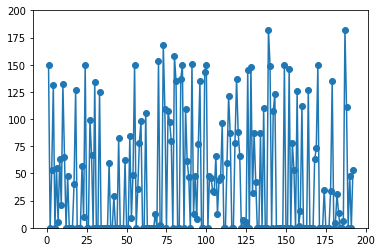

In [27]:
df_spins.coal2.plot(style='o-', ylim=[0,200])

Now sum all unit reserves to compute the _global_ spinning reserve.
Sum all columns of the DataFrame to get an aggregated time series. Use the *pandas* **sum** method
with axis=1 (for rows).

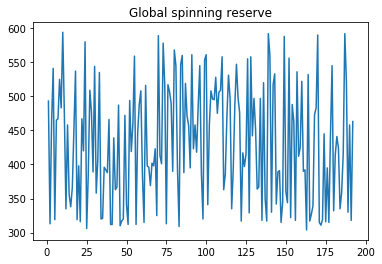

In [28]:
global_spin = df_spins.sum(axis=1)
global_spin.plot(title="Global spinning reserve")

#### Number of plants online by period

The total number of plants online at each period t is the sum of in_use variables for all units at this period.
Again, use the *pandas* sum with axis=1 (for rows) to sum over all units.

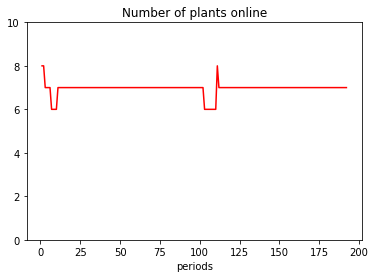

In [29]:
df_used.sum(axis=1).plot(title="Number of plants online", kind='line', style="r-", ylim=[0, len(units)])

#### Costs by period

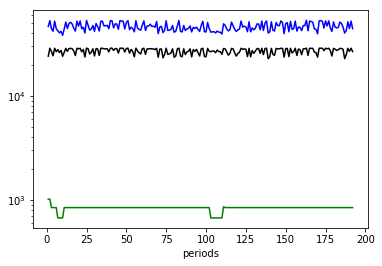

In [30]:
# extract unit cost data
all_costs = ["fixed_cost", "variable_cost", "start_cost", "co2_cost"]
df_costs = df_up[all_costs]

running_cost = df_used * df_costs.fixed_cost
startup_cost = df_started * df_costs.start_cost
variable_cost = df_prods * df_costs.variable_cost
co2_cost = df_prods * df_costs.co2_cost
total_cost = running_cost + startup_cost + variable_cost + co2_cost

running_cost.sum(axis=1).plot(style='g')
startup_cost.sum(axis=1).plot(style='r')
variable_cost.sum(axis=1).plot(style='b',logy=True)
co2_cost.sum(axis=1).plot(style='k')

#### Cost breakdown by unit and by energy

Text(0.5,1,'total cost by energy type')

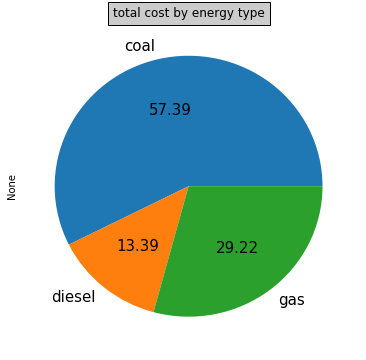

In [31]:
# Calculate sum by column (by default, axis = 0) to get total cost for each unit
cost_by_unit = total_cost.sum()

# Create a dictionary storing energy type for each unit, from the corresponding pandas Series
unit_energies = df_up.energy.to_dict()

# Group cost by unit type and plot total cost by energy type in a pie chart
gb = cost_by_unit.groupby(unit_energies)
# gb.sum().plot(kind='pie')
gb.sum().plot.pie(figsize=(6, 6),autopct='%.2f',fontsize=15)

plt.title('total cost by energy type', bbox={'facecolor':'0.8', 'pad':5})

### Arbitration between CO<sub>2</sub> cost and economic cost

Economic cost and CO<sub>2</sub> cost usually push in opposite directions.
In the previous section, you minimized the raw sum of economic cost and CO<sub>2</sub> cost, without weights.
But how much further could you reduce CO<sub>2</sub> emissions, if economic cost was not important? 
To find this out, solve again with CO<sub>2</sub> cost as the only objective.


In [32]:
# first retrieve the co2 and economic kpis
co2_kpi = ucpm.kpi_by_name("co2") # does a name matching
eco_kpi = ucpm.kpi_by_name("eco")
prev_co2_cost = co2_kpi.compute()
prev_eco_cost = eco_kpi.compute()
print("* current CO2 cost is: {}".format(prev_co2_cost))
print("* current $$$ cost is: {}".format(prev_eco_cost))
# now set the objective
old_objective = ucpm.objective_expr # save it
ucpm.minimize(co2_kpi.as_expression())

* current CO2 cost is: 5183324.500000002
* current $$$ cost is: 9029757.563900148


In [33]:
assert ucpm.solve(), "Solve failed"

In [34]:
min_co2_cost = ucpm.objective_value
min_co2_eco_cost = eco_kpi.compute()
print("* absolute minimum for CO2 cost is {}".format(min_co2_cost))
print("* at this point $$$ cost is {}".format(min_co2_eco_cost))

* absolute minimum for CO2 cost is 3399032.0
* at this point $$$ cost is 12433527.060000222


As expected, you get a significantly lower CO<sub>2</sub> cost when minimized alone, at the price of a higher economic cost.

You can do a similar analysis for economic cost to estimate the absolute minimum of
the economic cost, regardless of CO<sub>2</sub> cost.

In [35]:
# minimize only economic cost
ucpm.minimize(eco_kpi.as_expression())

In [36]:
assert ucpm.solve(), "Solve failed"

In [37]:
min_eco_cost = ucpm.objective_value
min_eco_co2_cost = co2_kpi.compute()
print("* absolute minimum for $$$ cost is {}".format(min_eco_cost))
print("* at this point CO2 cost is {}".format(min_eco_co2_cost))

* absolute minimum for $$$ cost is 8886788.6474
* at this point CO2 cost is 5375788.000000001


Again, the absolute minimum for economic cost is lower than the figure you obtained in the original model where you minimized the _sum_ of economic and CO<sub>2</sub> costs, but here the CO<sub>2</sub> is significantly increased.

But what happens in between these two extreme points?

To investigate this, divide the interval of CO<sub>2</sub> cost values in smaller intervals, add an upper limit on CO<sub>2</sub>,
and minimize economic cost with this constraint. This will give you a Pareto optimal point with at most this CO<sub>2</sub> value.

To avoid adding many constraints, add only one constraint with an extra variable, and change only the upper bound
of this CO<sub>2</sub> limit variable between successive solves.

Then iterate (with a fixed number of iterations) and collect the cost values. 

In [38]:
# add extra variable
co2_limit = ucpm.continuous_var(lb=0)
# add a named constraint which limits total co2 cost to this variable:
max_co2_ctname = "ct_max_co2"
co2_ct = ucpm.add_constraint(co2_kpi.as_expression() <= co2_limit, max_co2_ctname)     

In [39]:
co2min = min_co2_cost
co2max = min_eco_co2_cost
def explore_ucp(nb_iters, eps=1e-5):

    step = (co2max-co2min)/float(nb_iters)
    co2_ubs = [co2min + k * step for k in range(nb_iters+1)]

    # ensure eco minimized
    ucpm.minimize(eco_kpi.as_expression())
    all_co2s = []
    all_ecos = []
    for k in range(nb_iters+1):
        co2_ub = co2min + k * step
        print(" iteration #{0} co2_ub={1}".format(k, co2_ub))
        co2_limit.ub = co2_ub + eps
        assert ucpm.solve() is not None, "Solve failed"
        cur_co2 = co2_kpi.compute()
        cur_eco = eco_kpi.compute()
        all_co2s.append(cur_co2)
        all_ecos.append(cur_eco)
    return all_co2s, all_ecos

In [40]:
#explore the co2/eco frontier in 50 points
co2s, ecos = explore_ucp(nb_iters=50)

 iteration #0 co2_ub=3399032.0
 iteration #1 co2_ub=3438567.12
 iteration #2 co2_ub=3478102.24
 iteration #3 co2_ub=3517637.36
 iteration #4 co2_ub=3557172.48
 iteration #5 co2_ub=3596707.6
 iteration #6 co2_ub=3636242.72
 iteration #7 co2_ub=3675777.8400000003
 iteration #8 co2_ub=3715312.96
 iteration #9 co2_ub=3754848.08
 iteration #10 co2_ub=3794383.2
 iteration #11 co2_ub=3833918.3200000003
 iteration #12 co2_ub=3873453.4400000004
 iteration #13 co2_ub=3912988.56
 iteration #14 co2_ub=3952523.68
 iteration #15 co2_ub=3992058.8000000003
 iteration #16 co2_ub=4031593.9200000004
 iteration #17 co2_ub=4071129.04
 iteration #18 co2_ub=4110664.16
 iteration #19 co2_ub=4150199.2800000003
 iteration #20 co2_ub=4189734.4000000004
 iteration #21 co2_ub=4229269.5200000005
 iteration #22 co2_ub=4268804.640000001
 iteration #23 co2_ub=4308339.760000001
 iteration #24 co2_ub=4347874.880000001
 iteration #25 co2_ub=4387410.0
 iteration #26 co2_ub=4426945.12
 iteration #27 co2_ub=4466480.24
 iter

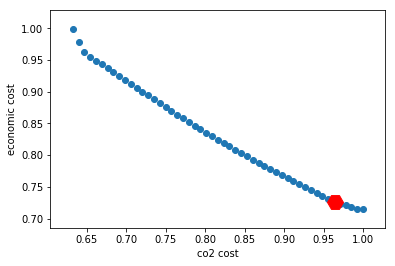

In [41]:
# normalize all values by dividing by their maximum
eco_max = min_co2_eco_cost
nxs = [c / co2max for c in co2s]
nys = [e / eco_max for e in ecos]
# plot a scatter chart of x=co2, y=costs
plt.scatter(nxs, nys)
# plot as one point
plt.plot(prev_co2_cost/co2max, prev_eco_cost/eco_max, "rH", markersize=16)
plt.xlabel("co2 cost")
plt.ylabel("economic cost")
plt.show()

This figure demonstrates that the result obtained in the initial model clearly favored
economic cost over CO<sub>2</sub> cost: CO<sub>2</sub> cost is well above 95% of its maximum value.

## Summary

You have learned how to set up and use IBM Decision Optimization CPLEX Modeling for Python to formulate a Mathematical Programming model and solve it with IBM Decision Optimization.

#### References
* <a href="https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html" target="_blank" rel="noopener noreferrer">Decision Optimization CPLEX Modeling for Python documentation</a>
* <a href="https://dataplatform.cloud.ibm.com/docs/content/getting-started/welcome-main.html?audience=wdp&context=wdp" target="_blank" rel="noopener noreferrer">Watson Studio documentation</a>


<hr>
Copyright © 2017-2018. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>